In [1]:
cd ..

/Project/melodyExtraction/melodyExtraction_JDC


In [2]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from keras.utils import multi_gpu_model
from scipy.signal import medfilt
from model import *

np.random.seed(1337)
class Options(object):
    def __init__(self):
        self.num_spec = 513
        self.input_size = 31
        self.batch_size = 64

        self.use_multi_gpu = True
        self.resolution = 16
        self.figure = False

Using TensorFlow backend.


In [3]:
def spec_extraction(file_name,win_size):
    print(file_name)

    x_test = []
    y, sr = librosa.load(file_name, sr=8000)

    S = librosa.core.stft(y, n_fft=1024, hop_length=80*1, win_length=1024)
    x_spec = np.abs(S)
    x_spec  = librosa.core.power_to_db(x_spec,ref=np.max)
    x_spec = x_spec.astype(np.float32)
    num_frames = x_spec.shape[1]

    # for padding
    padNum = num_frames % win_size
    if padNum != 0:
        len_pad = win_size - padNum
        padding_feature = np.zeros(shape=(513, len_pad))
        x_spec = np.concatenate((x_spec, padding_feature), axis=1)
        num_frames = num_frames + len_pad

    for j in range(0, num_frames, win_size):
        x_test_tmp = x_spec[:, range(j, j + win_size)].T
        x_test.append(x_test_tmp)
    x_test = np.array(x_test)

    # for normalization
    x_train_mean = np.load('./x_data_mean_total_31.npy')
    x_train_std = np.load('./x_data_std_total_31.npy')
    x_test = (x_test-x_train_mean)/(x_train_std+0.0001)
    x_test = x_test[:, :, :, np.newaxis]

    return x_test, x_spec


In [4]:
options = Options()

def main(file_name):
 
    pitch_range = np.arange(38, 83 + 1.0/options.resolution, 1.0/options.resolution)
    pitch_range = np.concatenate([np.zeros(1), pitch_range])
    
    '''  Extracting Features '''
    X_test, X_spec = spec_extraction(file_name=file_name, win_size=options.input_size)
    
    '''  Load model & weights '''
    model = melody_ResNet_joint_add(options)
    weight_name = './weights/ResNet_joint_add_L(CE_G)_N(0).hdf5'
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.load_weights(weight_name)
    y_predict = parallel_model.predict(X_test, batch_size=options.batch_size, verbose=1)

    num_total = y_predict[0].shape[0] * y_predict[0].shape[1]
    est_pitch = np.zeros(num_total)
    index_predict = np.zeros(num_total)        
    
    '''  Prediction '''
    y_predict = np.reshape(y_predict[0], (num_total, y_predict[0].shape[2]))  # origin
    for i in range(y_predict.shape[0]):
        index_predict[i] = np.argmax(y_predict[i, :])
        pitch_MIDI = pitch_range[np.int32(index_predict[i])]
        if pitch_MIDI >= 38 and pitch_MIDI <= 83:
            est_pitch[i] = 2 ** ((pitch_MIDI - 69) / 12.) * 440
    est_pitch = medfilt(est_pitch, 5)

    '''  Plot '''
    endpoint = 3000
    ii = (num_total // endpoint)
    for i in range(ii):
        start = endpoint * i
        end = start+ endpoint
        fig = plt.figure(figsize=(20,20))
        plt.imshow(X_spec[:,start:end], origin='lower')
        plt.plot(est_pitch[start:end],'r',linewidth=1)
        fig.tight_layout()

        # plt.savefig('test.pdf', bbox_inches='tight')
        plt.show()

/Project/dataset/musdb18/train/James May - All Souls Moon.stem.mp4
713/713 [==============================] - 3s 5ms/step


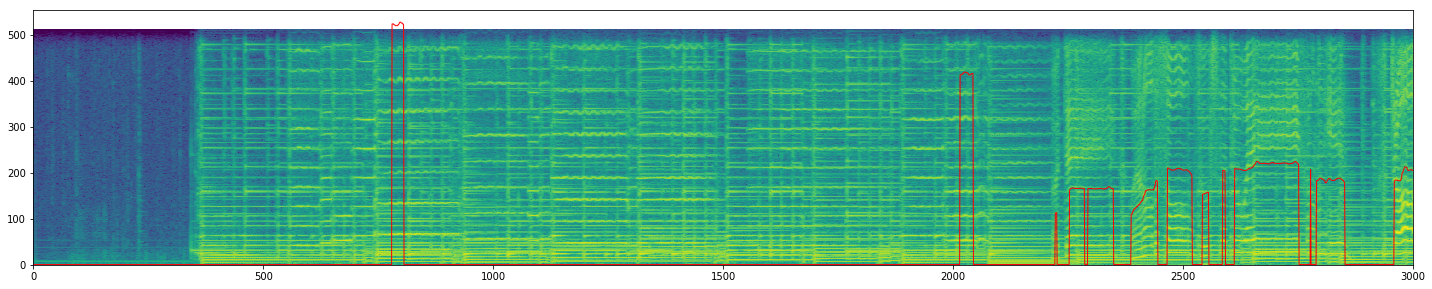

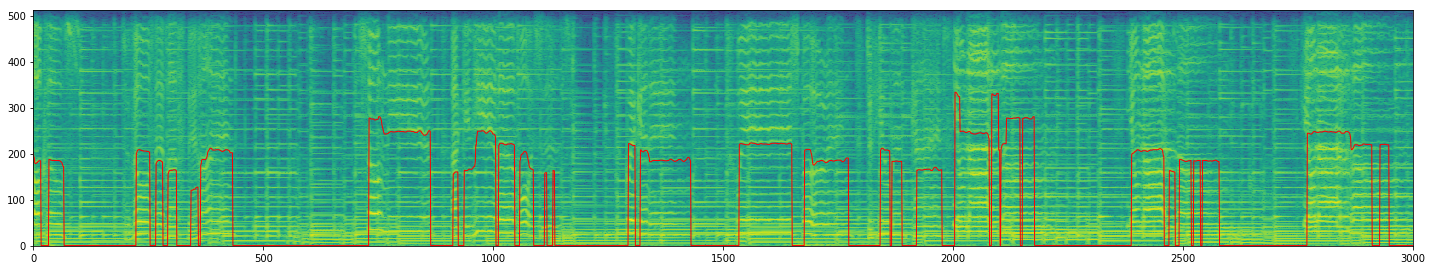

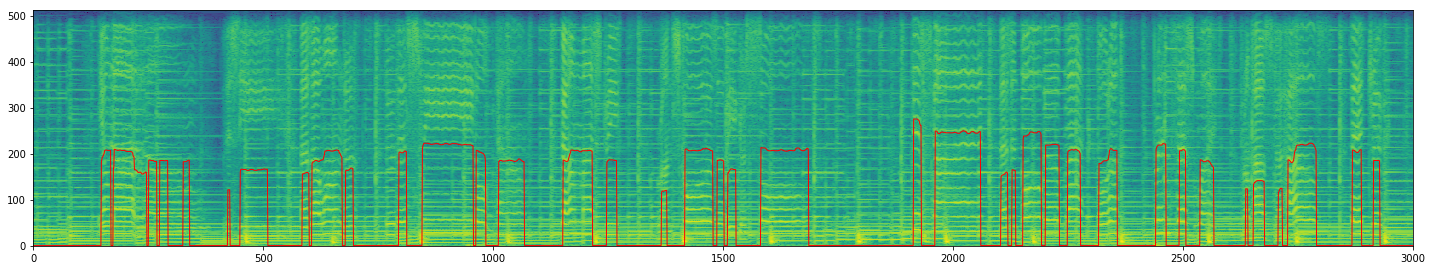

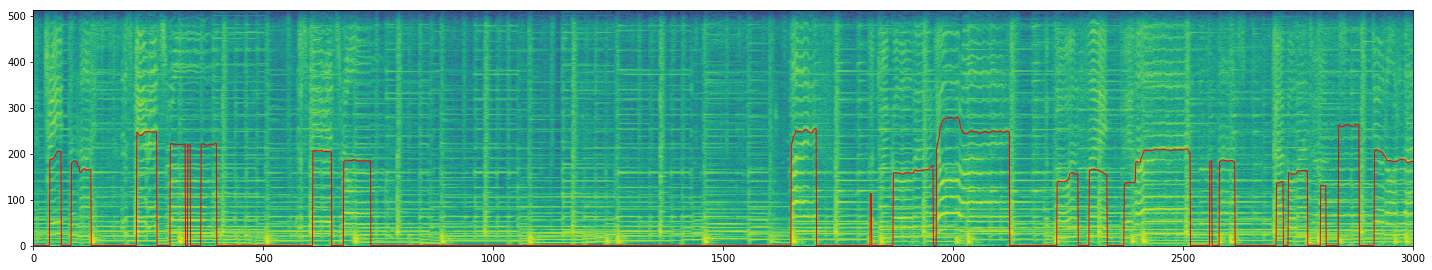

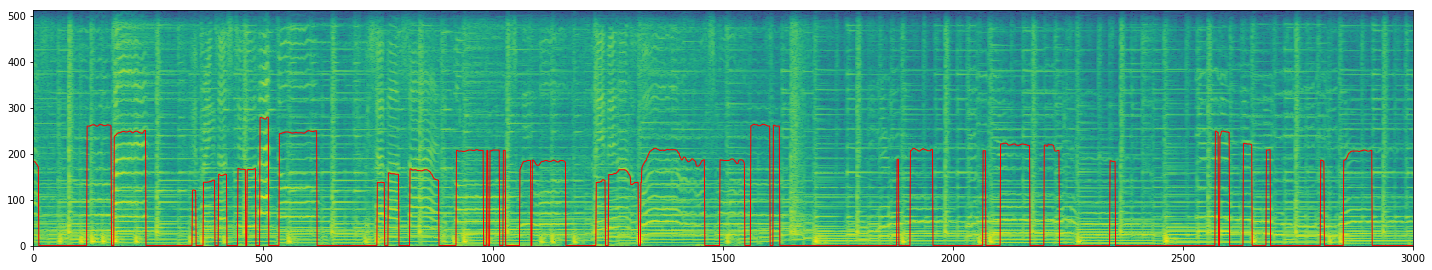

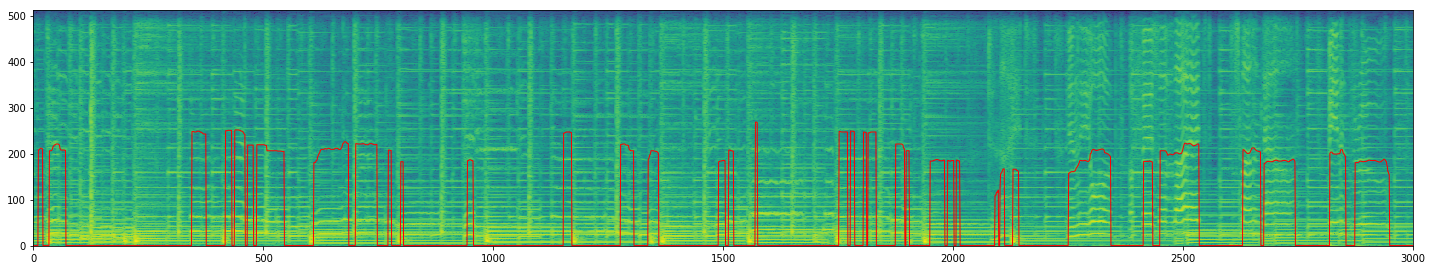

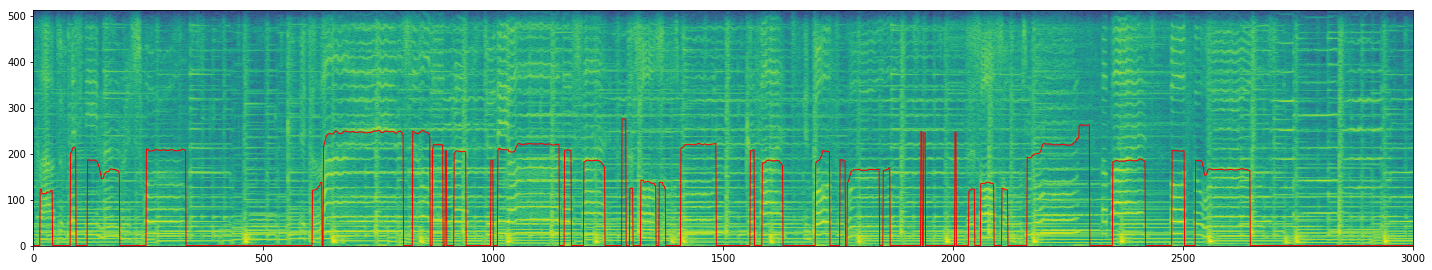

In [5]:
if __name__ == '__main__':

    file_name = '/Project/dataset/musdb18/train/James May - All Souls Moon.stem.mp4'
    main(file_name = file_name)